In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from utils.data import load_data, prepare_data
from utils.model import save_idata

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
df = load_data('data/SP1.csv')
df.head()

Div        Date   Time    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  \
0  SP1  16/08/2019  20:00  Ath Bilbao    Barcelona     1     0   H     0   
1  SP1  17/08/2019  16:00       Celta  Real Madrid     1     3   A     0   
2  SP1  17/08/2019  18:00    Valencia     Sociedad     1     1   D     0   
3  SP1  17/08/2019  19:00    Mallorca        Eibar     2     1   H     1   
4  SP1  17/08/2019  20:00     Leganes      Osasuna     0     1   A     0   

   HTAG  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  \
0     0  ...     1.97  0.75      1.93      2.00   1.91   2.01     2.02   
1     1  ...     2.63  1.00      1.82      1.97   1.85   2.07     2.00   
2     0  ...     1.82 -0.75      1.94      1.99   1.92   2.00     1.96   
3     0  ...     1.66  0.00      2.11      1.82   2.09   1.83     2.12   
4     0  ...     1.46 -0.50      1.89      2.04   1.90   2.01     1.95   

   MaxCAHA  AvgCAHH  AvgCAHA  
0     2.03     1.91     1.98  
1     2.20     1.82     2.06  
2     2.12     1.89     2.00  
3     1.88     2.07     1.83  
4     2.06     1.90     1.99  

[5 rows x 105 columns]

In [4]:
df, team_categorical = prepare_data(df)
df.head()

HomeTeam     AwayTeam  HomeGoals  AwayGoals  HomeTeamId  AwayTeamId
0  Ath Bilbao    Barcelona          1          0           1           3
1       Celta  Real Madrid          1          3           5          14
2    Valencia     Sociedad          1          1          17          16
3    Mallorca        Eibar          2          1          12           6
4     Leganes      Osasuna          0          1          10          13

In [5]:
n_teams = len(df.HomeTeam.unique())
print(f'Total teams = {n_teams}')

Total teams = 20


## Model 1

No home advantage. 

attack_group_mean ~ Normal(0, 10)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 10)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)

In [6]:
dims = {
    'home_team_id': ['match'],
    'away_team_id': ['match'],
    'home_goals': ['match'],
    'away_goals': ['match'],
    'attack_team': ['team'],
    'defense_team': ['team']
}

In [7]:
with pm.Model() as model_1:
    home_team_id = pm.Data('home_team_id', df.HomeTeamId)
    away_team_id = pm.Data('away_team_id', df.AwayTeamId)
    
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team = pm.Normal('attack_team', mu=attack_group_mean, sd=attack_group_sd, shape=n_teams)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team = pm.Normal('defense_team', mu=defense_group_mean, sd=defense_group_sd, shape=n_teams)
    
    home_rate = pm.math.exp(attack_team[home_team_id] - defense_team[away_team_id])
    away_rate = pm.math.exp(attack_team[away_team_id] - defense_team[home_team_id])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    idata_1 = pm.sample(1000, tune=1000, return_inferencedata=True,
                        idata_kwargs={
                            'coords': {'match': df.index, 'team': team_categorical.categories},
                            'dims': dims
                        })

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team, defense_group_sd, defense_group_mean, attack_team, attack_group_sd, attack_group_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
There were 821 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.027878566397935785, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7178406266527636, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66ea71de80>,
      dtype=object)

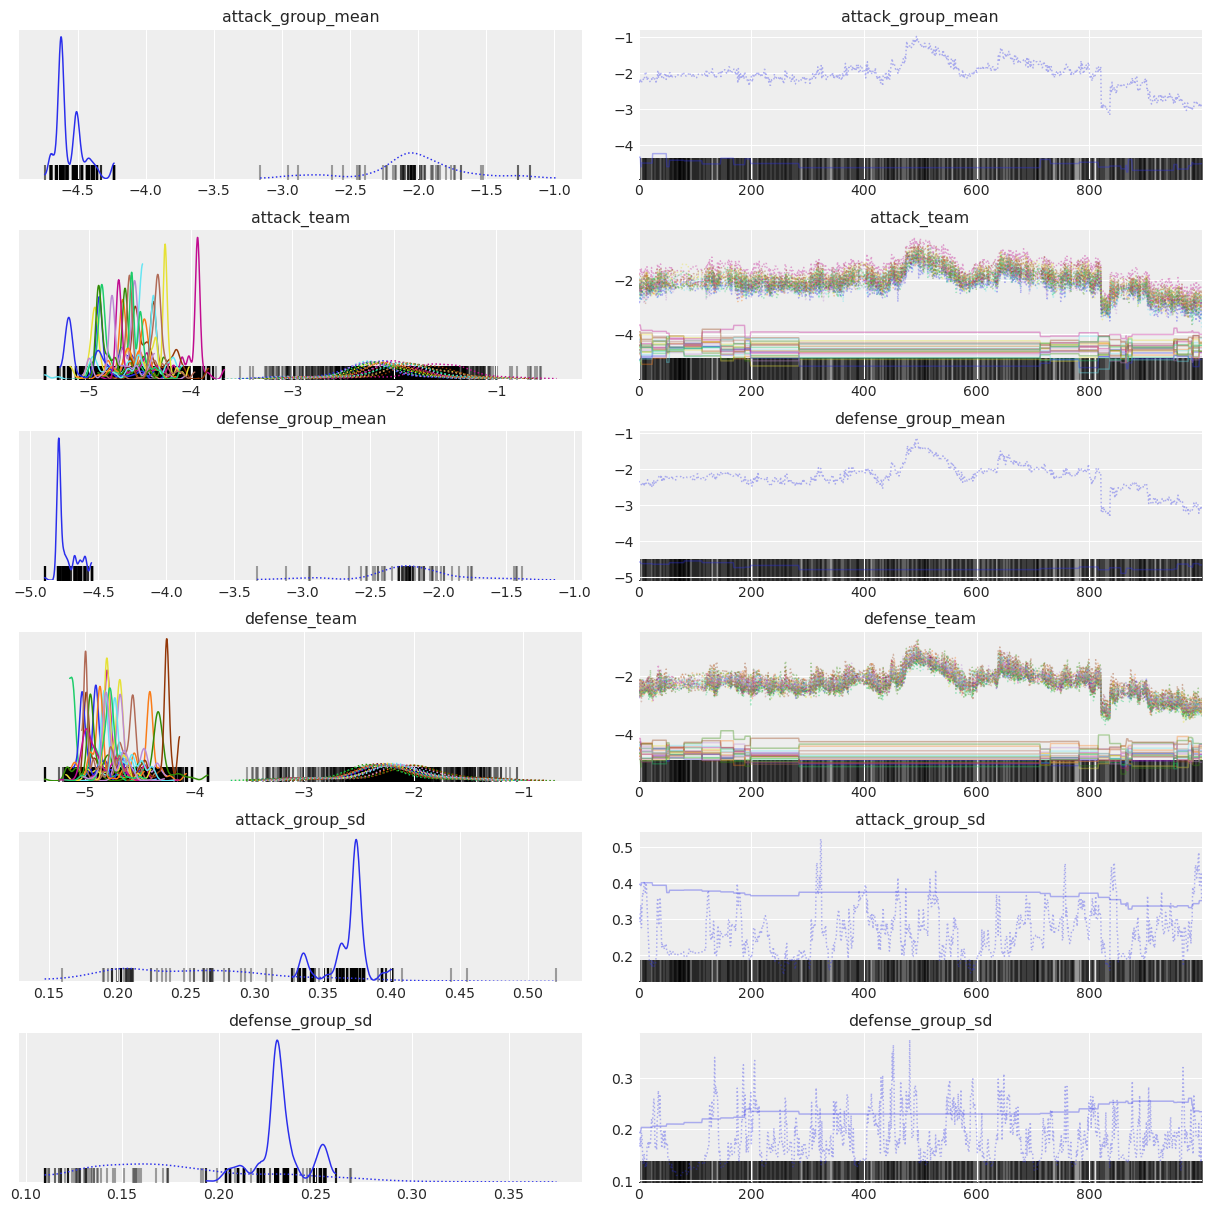

In [8]:
az.plot_trace(idata_1, compact=True)

* Too many divergences in model 1.
* Chains do not converge and mix properly.
* R hat statistic too large

Need to reparametrize the model

## Model 1 non-centered parametrization

In [11]:
dims = {
    'home_team_id': ['match'],
    'away_team_id': ['match'],
    'home_goals': ['match'],
    'away_goals': ['match'],
    'attack_team_z': ['team'],
    'defense_team_z': ['team'],
    'attack_team': ['team'],
    'defense_team': ['team']
}

In [16]:
with pm.Model() as model_1_nc:
    home_team_id = pm.Data('home_team_id', df.HomeTeamId)
    away_team_id = pm.Data('away_team_id', df.AwayTeamId)
    
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team = pm.Deterministic('attack_team', attack_group_mean + attack_group_sd * attack_team_z)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team = pm.Deterministic('defense_team', defense_group_mean + defense_group_sd * defense_team_z)
    
    home_rate = pm.math.exp(attack_team[home_team_id] - defense_team[away_team_id])
    away_rate = pm.math.exp(attack_team[away_team_id] - defense_team[home_team_id])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    
    idata_1_nc = pm.sample(1000, tune=1000, return_inferencedata=True,
                          idata_kwargs={
                              'coords': {'match': df.index, 'team': team_categorical.categories},
                              'dims': dims
                          })

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack_team_z, attack_group_sd, attack_group_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
save_idata(idata_1_nc, 'model_1_nc')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66cf310850>,
      dtype=object)

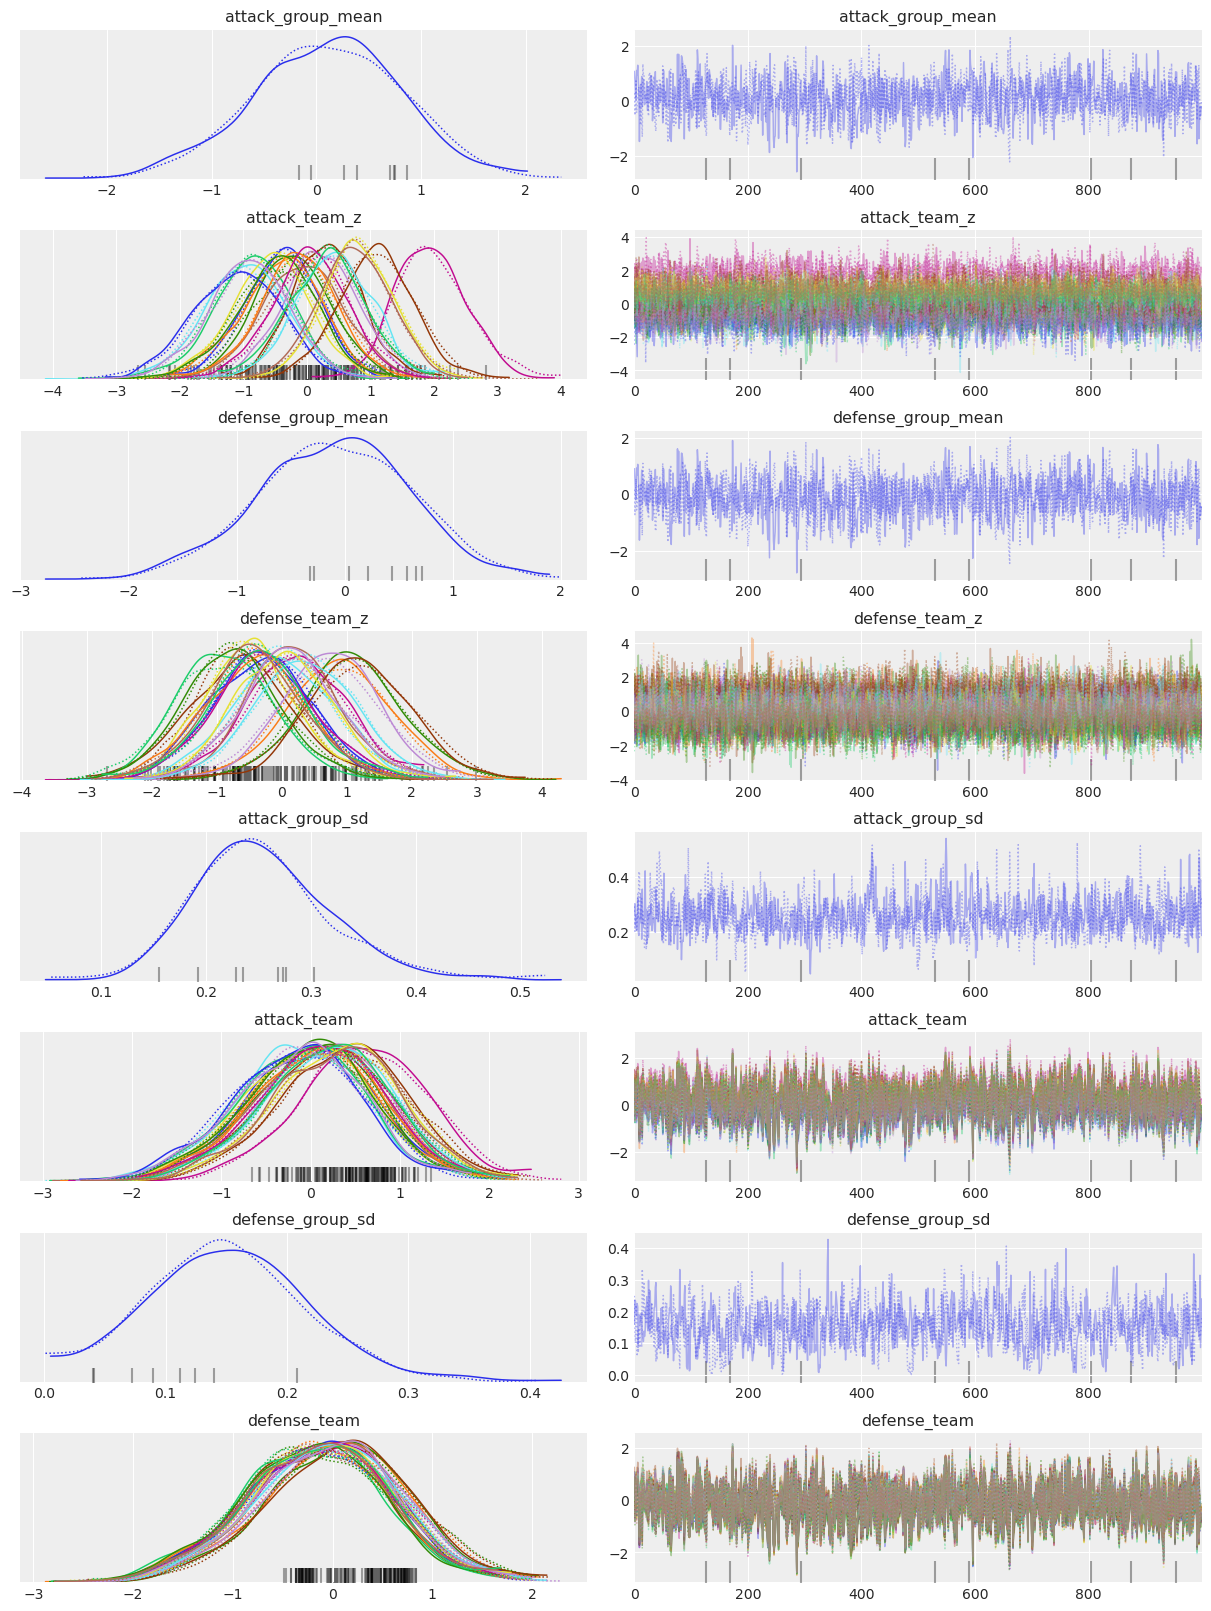

In [18]:
az.plot_trace(idata_1_nc, compact=True)

In [28]:
idata_1_nc.posterior.attack_team.data.shape

(2, 1000, 20)

Text(0, 0.5, 'Density')

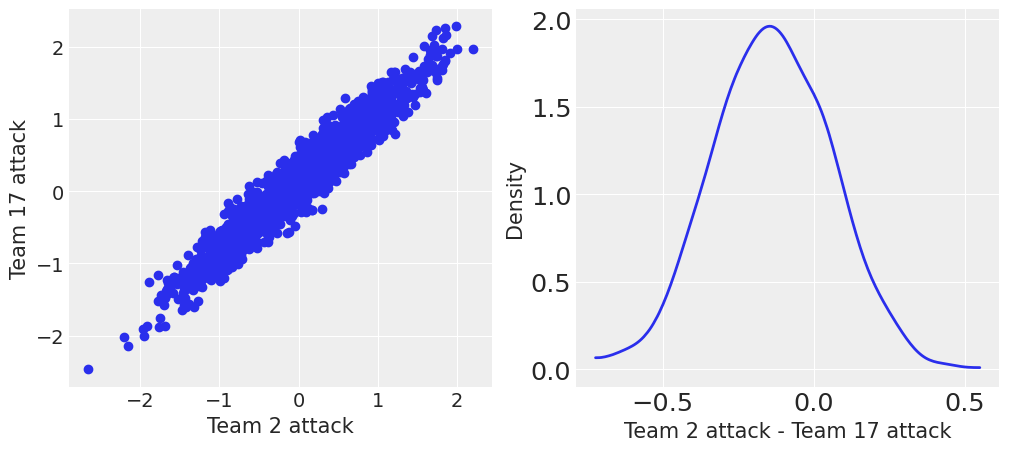

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

post_attack_team = idata_1_nc.posterior.attack_team.data.reshape(2000, 20)
axs[0].plot(post_attack_team[:, 2], post_attack_team[:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(post_attack_team[:, 2] - post_attack_team[:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

In [38]:
#pm.trace_to_dataframe(trace_1_nc, varnames=['attack_team']).corr()
pd.DataFrame(np.corrcoef(post_attack_team.T))

0         1         2         3         4         5         6  \
0   1.000000  0.960877  0.959342  0.961914  0.961515  0.953751  0.961226   
1   0.960877  1.000000  0.959092  0.957359  0.963190  0.953707  0.957857   
2   0.959342  0.959092  1.000000  0.961479  0.964298  0.953756  0.956619   
3   0.961914  0.957359  0.961479  1.000000  0.966585  0.954360  0.957755   
4   0.961515  0.963190  0.964298  0.966585  1.000000  0.953649  0.962977   
5   0.953751  0.953707  0.953756  0.954360  0.953649  1.000000  0.954866   
6   0.961226  0.957857  0.956619  0.957755  0.962977  0.954866  1.000000   
7   0.959569  0.956875  0.959362  0.954944  0.959837  0.956981  0.955966   
8   0.962088  0.958523  0.960209  0.965026  0.960073  0.955553  0.958153   
9   0.964794  0.957270  0.958615  0.961824  0.963361  0.955811  0.957490   
10  0.954300  0.951031  0.949042  0.947567  0.952916  0.958452  0.950769   
11  0.959871  0.959842  0.961801  0.960800  0.963783  0.955750  0.958717   
12  0.959774  0.954805  0.954546  0.958860  0.960723  0.954833  0.959224   
13  0.962186  0.958071  0.960314  0.962149  0.961931  0.953219  0.958283   
14  0.962918  0.959839  0.959001  0.970508  0.962959  0.952585  0.957882   
15  0.959634  0.957486  0.959635  0.964458  0.962255  0.955260  0.958023   
16  0.962094  0.957308  0.960818  0.969660  0.966804  0.954064  0.959492   
17  0.960324  0.955435  0.962665  0.967049  0.964050  0.954128  0.957656   
18  0.956895  0.955635  0.954472  0.954653  0.961797  0.958165  0.960420   
19  0.961849  0.963284  0.961798  0.967536  0.967405  0.952191  0.959186   

           7         8         9        10        11        12        13  \
0   0.959569  0.962088  0.964794  0.954300  0.959871  0.959774  0.962186   
1   0.956875  0.958523  0.957270  0.951031  0.959842  0.954805  0.958071   
2   0.959362  0.960209  0.958615  0.949042  0.961801  0.954546  0.960314   
3   0.954944  0.965026  0.961824  0.947567  0.960800  0.958860  0.962149   
4   0.959837  0.960073  0.963361  0.952916  0.963783  0.960723  0.961931   
5   0.956981  0.955553  0.955811  0.958452  0.955750  0.954833  0.953219   
6   0.955966  0.958153  0.957490  0.950769  0.958717  0.959224  0.958283   
7   1.000000  0.959082  0.953711  0.951991  0.958232  0.956926  0.958670   
8   0.959082  1.000000  0.960331  0.950406  0.961091  0.958911  0.959720   
9   0.953711  0.960331  1.000000  0.950462  0.958336  0.952859  0.956478   
10  0.951991  0.950406  0.950462  1.000000  0.950638  0.951308  0.951622   
11  0.958232  0.961091  0.958336  0.950638  1.000000  0.957286  0.960018   
12  0.956926  0.958911  0.952859  0.951308  0.957286  1.000000  0.955015   
13  0.958670  0.959720  0.956478  0.951622  0.960018  0.955015  1.000000   
14  0.955849  0.965565  0.960152  0.948134  0.961867  0.956936  0.960606   
15  0.955903  0.959481  0.959771  0.952058  0.960477  0.955292  0.959687   
16  0.954443  0.964405  0.962705  0.950373  0.962420  0.959535  0.964483   
17  0.955294  0.960034  0.959446  0.947499  0.961206  0.957499  0.962541   
18  0.957013  0.955851  0.953849  0.950620  0.956607  0.956658  0.956330   
19  0.957403  0.962829  0.961523  0.948084  0.961850  0.956698  0.960851   

          14        15        16        17        18        19  
0   0.962918  0.959634  0.962094  0.960324  0.956895  0.961849  
1   0.959839  0.957486  0.957308  0.955435  0.955635  0.963284  
2   0.959001  0.959635  0.960818  0.962665  0.954472  0.961798  
3   0.970508  0.964458  0.969660  0.967049  0.954653  0.967536  
4   0.962959  0.962255  0.966804  0.964050  0.961797  0.967405  
5   0.952585  0.955260  0.954064  0.954128  0.958165  0.952191  
6   0.957882  0.958023  0.959492  0.957656  0.960420  0.959186  
7   0.955849  0.955903  0.954443  0.955294  0.957013  0.957403  
8   0.965565  0.959481  0.964405  0.960034  0.955851  0.962829  
9   0.960152  0.959771  0.962705  0.959446  0.953849  0.961523  
10  0.948134  0.952058  0.950373  0.947499  0.950620  0.948084  
11  0.961867  0.960477  0.962420  0.9

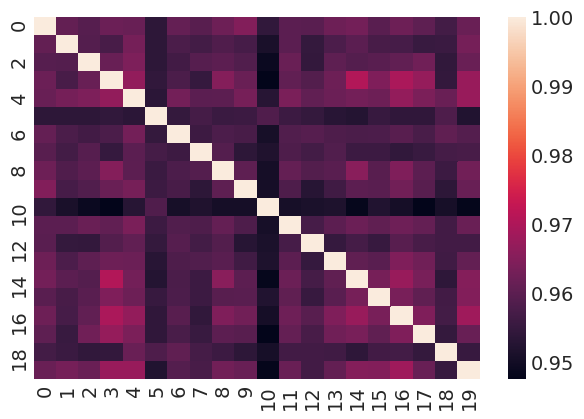

In [39]:
sns.heatmap(np.corrcoef(post_attack_team.T))

* Too much variance in parameter estimates.
* Model is unidentifiable. Adding any constant k to all the attack and defense parameters will lead to the same predictions
* Estimates are strongly correlated.
* Need to add some more constraints.

## Model 2

* No home team advantage.
* Add sum to one constraint on the attack and defense parameters of the teams.
* Non-centered parametrization

attack_group_mean ~ Normal(0, 10)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 10)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)  

$\sum_{i=1}^{20} attackteam_i$ = 0  
$\sum_{i=1}^{20} defenseteam_i$ = 0

In [7]:
import theano.tensor as tt

In [41]:
with pm.Model() as model_2:
    home_team_id = pm.Data('home_team_id', df.HomeTeamId)
    away_team_id = pm.Data('away_team_id', df.AwayTeamId)
    
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team_ = attack_group_mean + attack_group_sd * attack_team_z
    #attack_team = pm.Deterministic('attack_team', tt.concatenate([attack_team_, tt.stack(-tt.sum(attack_team_))]))
    attack_team = pm.Deterministic('attack_team', attack_team_ - tt.mean(attack_team_))
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team_ = defense_group_mean + defense_group_sd * defense_team_z
    #defense_team = pm.Deterministic('defense_team', tt.concatenate([defense_team_, tt.stack(-tt.sum(defense_team_))]))
    defense_team = pm.Deterministic('defense_team', defense_team_ - tt.mean(defense_team_))
    
    home_rate = pm.math.exp(attack_team[home_team_id] - defense_team[away_team_id])
    away_rate = pm.math.exp(attack_team[away_team_id] - defense_team[home_team_id])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    idata_2 = pm.sample(1000, tune=1000, return_inferencedata=True,
                          idata_kwargs={
                              'coords': {'match': df.index, 'team': team_categorical.categories},
                              'dims': dims
                          })

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack_team_z, attack_group_sd, attack_group_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [43]:
save_idata(idata_2, 'model_2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66c8649ac0>,
      dtype=object)

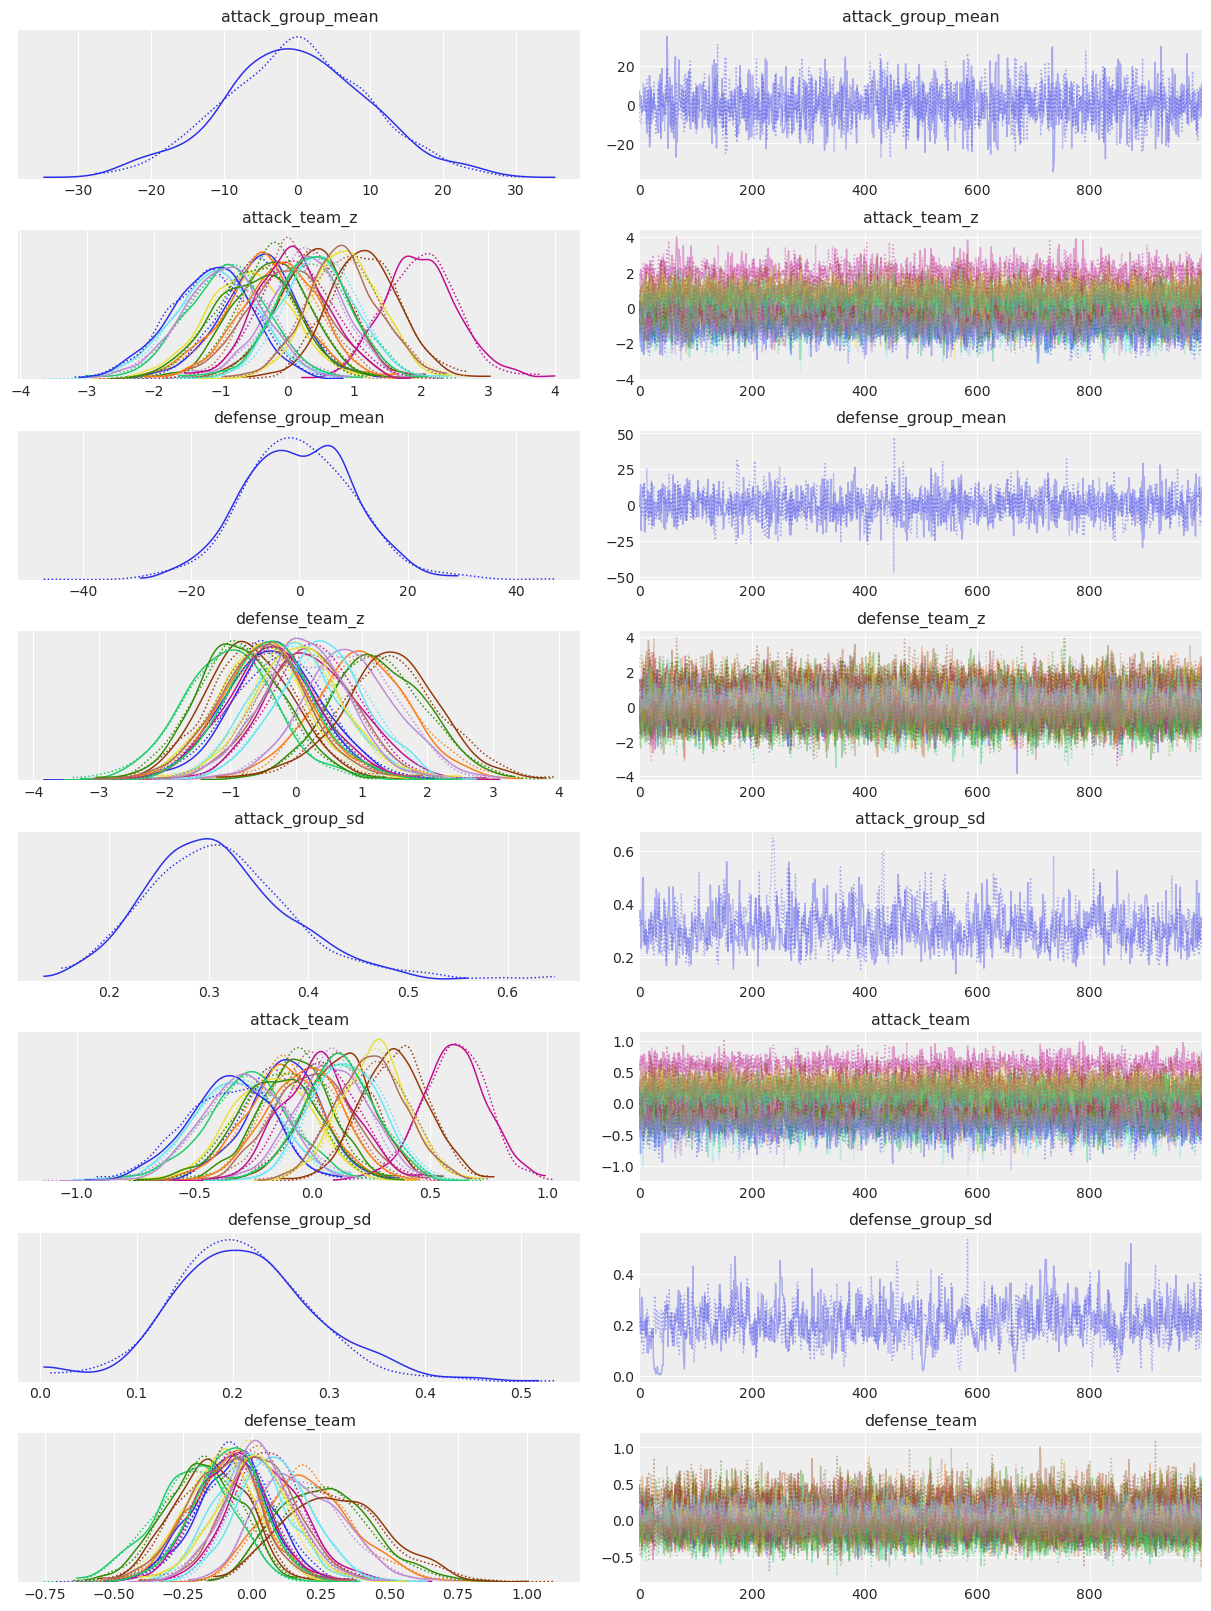

In [44]:
az.plot_trace(idata_2, compact=True)

In [45]:
az.summary(idata_2, var_names=['attack_group_mean', 'attack_group_sd', 'attack_team'],
           hdi_prob=0.89)

mean      sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
attack_group_mean -0.117  10.107   -17.136     15.399      0.176    0.265   
attack_group_sd    0.311   0.073     0.190      0.413      0.003    0.002   
attack_team[0]    -0.129   0.161    -0.406      0.108      0.003    0.003   
attack_team[1]    -0.129   0.163    -0.374      0.147      0.003    0.003   
attack_team[2]    -0.070   0.150    -0.297      0.175      0.003    0.003   
attack_team[3]     0.602   0.138     0.390      0.821      0.003    0.002   
attack_team[4]     0.115   0.148    -0.104      0.376      0.003    0.003   
attack_team[5]    -0.329   0.183    -0.610     -0.032      0.004    0.003   
attack_team[6]    -0.173   0.169    -0.438      0.092      0.003    0.003   
attack_team[7]    -0.283   0.183    -0.595     -0.016      0.004    0.003   
attack_team[8]     0.082   0.153    -0.151      0.332      0.003    0.003   
attack_team[9]    -0.005   0.158    -0.257      0.247      0.003    0.004   
attack_team[10]   -0.358   0.181    -0.653     -0.090      0.004    0.003   
attack_team[11]   -0.039   0.158    -0.290      0.207      0.003    0.003   
attack_team[12]   -0.150   0.169    -0.403      0.124      0.003    0.003   
attack_team[13]    0.031   0.154    -0.201      0.274      0.003    0.004   
attack_team[14]    0.350   0.141     0.142      0.590      0.003    0.002   
attack_team[15]    0.148   0.150    -0.093      0.382      0.003    0.003   
attack_team[16]    0.262   0.144     0.041      0.496      0.003    0.002   
attack_team[17]    0.117   0.155    -0.137      0.356      0.003    0.003   
attack_team[18]   -0.293   0.178    -0.561     -0.005      0.004    0.003   
attack_team[19]    0.251   0.150     0.003      0.476      0.003    0.002   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
attack_group_mean    3302.0   726.0    3281.0    1208.0   1.00  
attack_group_sd       536.0   500.0     596.0     633.0   1.01  
attack_team[0]       2550.0  1381.0    2547.0    1702.0   1.00  
attack_team[1]       2293.0  1206.0    2289.0    1233.0   1.00  
attack_team[2]       2512.0  1101.0    2543.0    1283.0   1.00  
attack_team[3]       1818.0  1818.0    1837.0    1280.0   1.00  
attack_team[4]       2023.0  1403.0    2034.0    1412.0   1.00  
attack_team[5]       1890.0  1558.0    1904.0    1204.0   1.00  
attack_team[6]       3081.0  1664.0    3090.0    1475.0   1.00  
attack_team[7]       2148.0  1750.0    2184.0    1302.0   1.00  
attack_team[8]       2761.0  1205.0    2803.0    1089.0   1.00  
attack_team[9]       2162.0   842.0    2165.0    1315.0   1.00  
attack_team[10]      2237.0  1777.0    2275.0    1334.0   1.00  
attack_team[11]      2933.0  1065.0    2929.0    1360.0   1.00  
attack_team[12]      2426.0  1330.0    2430.0    1405.0   1.00  
attack_team[13]      1948.0   897.0    1946.0    1192.0   1.00  
attack_team[14]      2422.0  2414.0    2432.0    1298.0   1.00  
attack_team[15]      2245.0  1652.0    2251.0    1391.0   1.00  
attack_team[16]      2473.0  2326.0    2492.0    1453.0   1.00  
attack_team[17]      2422.0  1241.0    2418.0    1354.0   1.00  
attack_team[18]      2409.0  1724.0    2391.0    1416.0   1.00  
attack_team[19]      2440.0  2040.0    2433.0    1506.0   1.00

In [46]:
az.summary(idata_2, var_names=['defense_group_mean', 'defense_group_sd', 'defense_team'],
           hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
defense_group_mean -0.044  9.841   -15.373     14.797      0.223    0.230   
defense_group_sd    0.210  0.074     0.094      0.324      0.003    0.002   
defense_team[0]    -0.059  0.137    -0.282      0.156      0.003    0.003   
defense_team[1]     0.211  0.158    -0.047      0.456      0.004    0.003   
defense_team[2]     0.263  0.168    -0.012      0.500      0.005    0.004   
defense_team[3]     0.056  0.133    -0.144      0.268      0.003    0.003   
defense_team[4]    -0.147  0.135    -0.369      0.051      0.003    0.002   
defense_team[5]    -0.001  0.133    -0.224      0.199      0.003    0.003   
defense_team[6]    -0.112  0.132    -0.332      0.093      0.003    0.002   
defense_team[7]    -0.214  0.143    -0.427      0.028      0.004    0.003   
defense_team[8]     0.177  0.152    -0.041      0.431      0.004    0.003   
defense_team[9]     0.032  0.133    -0.178      0.242      0.003    0.003   
defense_team[10]   -0.086  0.133    -0.314      0.105      0.003    0.003   
defense_team[11]   -0.093  0.135    -0.305      0.121      0.003    0.003   
defense_team[12]   -0.181  0.135    -0.387      0.039      0.004    0.003   
defense_team[13]   -0.072  0.131    -0.275      0.137      0.003    0.002   
defense_team[14]    0.306  0.183    -0.004      0.573      0.006    0.004   
defense_team[15]    0.083  0.133    -0.141      0.281      0.003    0.003   
defense_team[16]    0.000  0.133    -0.219      0.206      0.003    0.003   
defense_team[17]   -0.084  0.128    -0.288      0.110      0.003    0.002   
defense_team[18]    0.027  0.129    -0.179      0.233      0.003    0.003   
defense_team[19]   -0.106  0.136    -0.321      0.107      0.003    0.003   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
defense_group_mean    1945.0   913.0    1931.0    1285.0    1.0  
defense_group_sd       526.0   526.0     530.0     363.0    1.0  
defense_team[0]       2223.0  1072.0    2211.0    1274.0    1.0  
defense_team[1]       1387.0  1387.0    1362.0    1357.0    1.0  
defense_team[2]       1148.0  1148.0    1071.0     703.0    1.0  
defense_team[3]       2252.0  1114.0    2290.0    1475.0    1.0  
defense_team[4]       1651.0  1536.0    1634.0    1173.0    1.0  
defense_team[5]       2146.0   870.0    2140.0    1497.0    1.0  
defense_team[6]       2158.0  1569.0    2142.0    1359.0    1.0  
defense_team[7]       1397.0  1397.0    1357.0    1320.0    1.0  
defense_team[8]       1432.0  1432.0    1423.0    1502.0    1.0  
defense_team[9]       2724.0   998.0    2725.0    1504.0    1.0  
defense_team[10]      2205.0  1063.0    2180.0    1325.0    1.0  
defense_team[11]      2259.0  1339.0    2220.0    1299.0    1.0  
defense_team[12]      1388.0  1388.0    1378.0    1379.0    1.0  
defense_team[13]      2093.0  1498.0    2089.0    1530.0    1.0  
defense_team[14]      1002.0  1002.0     934.0     475.0    1.0  
defense_team[15]      1892.0  1155.0    1988.0    1471.0    1.0  
defense_team[16]      2090.0   914.0    2094.0    1342.0    1.0  
defense_team[17]      1709.0  1441.0    1687.0    1317.0    1.0  
defense_team[18]      1818.0  1112.0    1830.0    1469.0    1.0  
defense_team[19]      2227.0  1311.0    2182.0    1522.0    1.0

Text(0, 0.5, 'Density')

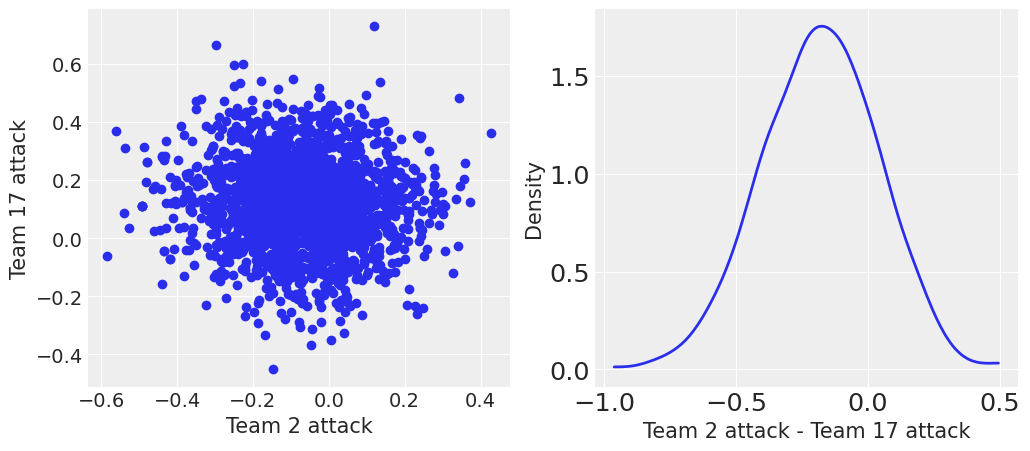

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

post_attack_team = idata_2.posterior.attack_team.data.reshape(2000, 20)
axs[0].plot(post_attack_team[:, 2], post_attack_team[:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(post_attack_team[:, 2] - post_attack_team[:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

In [48]:
#pm.trace_to_dataframe(trace_2, varnames=['attack_team']).corr()
pd.DataFrame(np.corrcoef(post_attack_team.T))

0         1         2         3         4         5         6  \
0   1.000000 -0.071685 -0.029205 -0.071194 -0.062825 -0.065511 -0.015387   
1  -0.071685  1.000000 -0.100404 -0.069712 -0.038834  0.003276 -0.049401   
2  -0.029205 -0.100404  1.000000 -0.038555 -0.101195 -0.109098 -0.044395   
3  -0.071194 -0.069712 -0.038555  1.000000 -0.002580 -0.191616 -0.096701   
4  -0.062825 -0.038834 -0.101195 -0.002580  1.000000 -0.039074 -0.009296   
5  -0.065511  0.003276 -0.109098 -0.191616 -0.039074  1.000000 -0.054717   
6  -0.015387 -0.049401 -0.044395 -0.096701 -0.009296 -0.054717  1.000000   
7  -0.058351 -0.027505 -0.084901 -0.125839 -0.067159 -0.011574 -0.035311   
8  -0.071358 -0.074220  0.014079 -0.002516 -0.044618 -0.037894 -0.083913   
9  -0.078639 -0.046939 -0.039354 -0.012383 -0.026821 -0.070455 -0.019528   
10 -0.010642  0.006008 -0.062407 -0.186565 -0.102083  0.015102 -0.031657   
11 -0.059754 -0.050856 -0.065597 -0.032956 -0.029100 -0.067070 -0.074432   
12 -0.034341 -0.054211 -0.058657 -0.105430 -0.069972 -0.000580 -0.053173   
13 -0.042827 -0.022956 -0.044124 -0.009602 -0.059499 -0.053963 -0.114729   
14 -0.033558 -0.069908  0.060046  0.137702 -0.030386 -0.124799 -0.092405   
15 -0.028203 -0.122341 -0.024527  0.049480 -0.056705 -0.099095 -0.105625   
16 -0.086034 -0.099826 -0.033720  0.052896  0.017224 -0.113467 -0.109794   
17 -0.062930 -0.042014 -0.036602  0.016157 -0.025334 -0.092629 -0.046253   
18 -0.068544 -0.014046 -0.037519 -0.137482 -0.124300 -0.008799 -0.023904   
19 -0.064719 -0.119344 -0.070933  0.092448 -0.025983 -0.102244 -0.032808   

           7         8         9        10        11        12        13  \
0  -0.058351 -0.071358 -0.078639 -0.010642 -0.059754 -0.034341 -0.042827   
1  -0.027505 -0.074220 -0.046939  0.006008 -0.050856 -0.054211 -0.022956   
2  -0.084901  0.014079 -0.039354 -0.062407 -0.065597 -0.058657 -0.044124   
3  -0.125839 -0.002516 -0.012383 -0.186565 -0.032956 -0.105430 -0.009602   
4  -0.067159 -0.044618 -0.026821 -0.102083 -0.029100 -0.069972 -0.059499   
5  -0.011574 -0.037894 -0.070455  0.015102 -0.067070 -0.000580 -0.053963   
6  -0.035311 -0.083913 -0.019528 -0.031657 -0.074432 -0.053173 -0.114729   
7   1.000000 -0.105172 -0.066257  0.013807 -0.068222 -0.027112 -0.076304   
8  -0.105172  1.000000 -0.136559 -0.059682 -0.031297 -0.066587 -0.060805   
9  -0.066257 -0.136559  1.000000 -0.072072 -0.083020 -0.032195  0.038292   
10  0.013807 -0.059682 -0.072072  1.000000 -0.034383 -0.036683 -0.054907   
11 -0.068222 -0.031297 -0.083020 -0.034383  1.000000 -0.078353 -0.096900   
12 -0.027112 -0.066587 -0.032195 -0.036683 -0.078353  1.000000 -0.048534   
13 -0.076304 -0.060805  0.038292 -0.054907 -0.096900 -0.048534  1.000000   
14 -0.164419 -0.019888 -0.039701 -0.144508 -0.019746 -0.138933 -0.096708   
15 -0.063715 -0.038907 -0.071648 -0.066637 -0.074001 -0.003359 -0.016130   
16 -0.076356 -0.015404 -0.069922 -0.140708 -0.044564 -0.075930 -0.080574   
17 -0.104637 -0.059217 -0.020812 -0.138183 -0.003388 -0.081036  0.007070   
18  0.056992 -0.001302 -0.104980  0.000614 -0.031893 -0.053275 -0.088251   
19 -0.132671 -0.042668 -0.018663 -0.117060 -0.035520 -0.076953 -0.028370   

          14        15        16        17        18        19  
0  -0.033558 -0.028203 -0.086034 -0.062930 -0.068544 -0.064719  
1  -0.069908 -0.122341 -0.099826 -0.042014 -0.014046 -0.119344  
2   0.060046 -0.024527 -0.033720 -0.036602 -0.037519 -0.070933  
3   0.137702  0.049480  0.052896  0.016157 -0.137482  0.092448  
4  -0.030386 -0.056705  0.017224 -0.025334 -0.124300 -0.025983  
5  -0.124799 -0.099095 -0.113467 -0.092629 -0.008799 -0.102244  
6  -0.092405 -0.105625 -0.109794 -0.046253 -0.023904 -0.032808  
7  -0.164419 -0.063715 -0.076356 -0.104637  0.056992 -0.132671  
8  -0.019888 -0.038907 -0.015404 -0.059217 -0.001302 -0.042668  
9  -0.039701 -0.071648 -0.069922 -0.020812 -0.104980 -0.018663  
10 -0.144508 -0.066637 -0.140708 -0.138183  0.000614 -0.117060  
11 -0.019746 -0.074001 -0.044564 -0.0

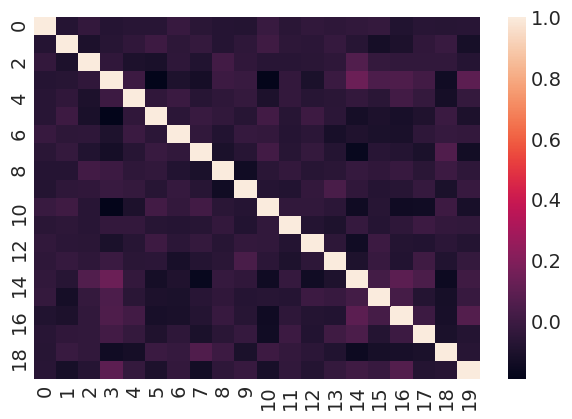

In [50]:
sns.heatmap(np.corrcoef(post_attack_team.T))

* The strong correlation between estimates for each team is gone.
* The model is identifiable.
* The distribution of difference between the 2 teams seems to be similar for model 1 with non-centered parametrization and model 2 but the correlation between the 2 teams' estimates is removed.
* Note that the color bar is different for model 1 and model 2 correlation heatmaps.

## Model 3

* Equal home team advantage for each team.
* Sum to one constraint on the attack and defense parameters of the teams.
* Non-centered parametrization

attack_group_mean ~ Normal(0, 10)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 10)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

home_advantage ~ Normal(0, 1)

log(home_rate<sub>i, j</sub>) = home_advantage + attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)  

$\sum_{i=1}^{20} attackteam_i$ = 0  
$\sum_{i=1}^{20} defenseteam_i$ = 0

In [15]:
with pm.Model() as model_3:
    home_team_id = pm.Data('home_team_id', df.HomeTeamId)
    away_team_id = pm.Data('away_team_id', df.AwayTeamId)
    
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team_ = attack_group_mean + attack_group_sd * attack_team_z
    attack_team = pm.Deterministic('attack_team', attack_team_ - tt.mean(attack_team_))
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team_ = defense_group_mean + defense_group_sd * defense_team_z
    defense_team = pm.Deterministic('defense_team', defense_team_ - tt.mean(defense_team_))
    
    home_advantage = pm.Normal('home_advantage', mu=0, sd=1)
    
    home_rate = pm.math.exp(home_advantage + attack_team[home_team_id] - defense_team[away_team_id])
    away_rate = pm.math.exp(attack_team[away_team_id] - defense_team[home_team_id])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    idata_3 = pm.sample(1000, tune=1000, return_inferencedata=True,
                          idata_kwargs={
                              'coords': {'match': df.index, 'team': team_categorical.categories},
                              'dims': dims
                          })

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [home_advantage, defense_team_z, defense_group_sd, defense_group_mean, attack_team_z, attack_group_sd, attack_group_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [16]:
save_idata(idata_3, 'model_3')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb02b3a31c0>,
      dtype=object)

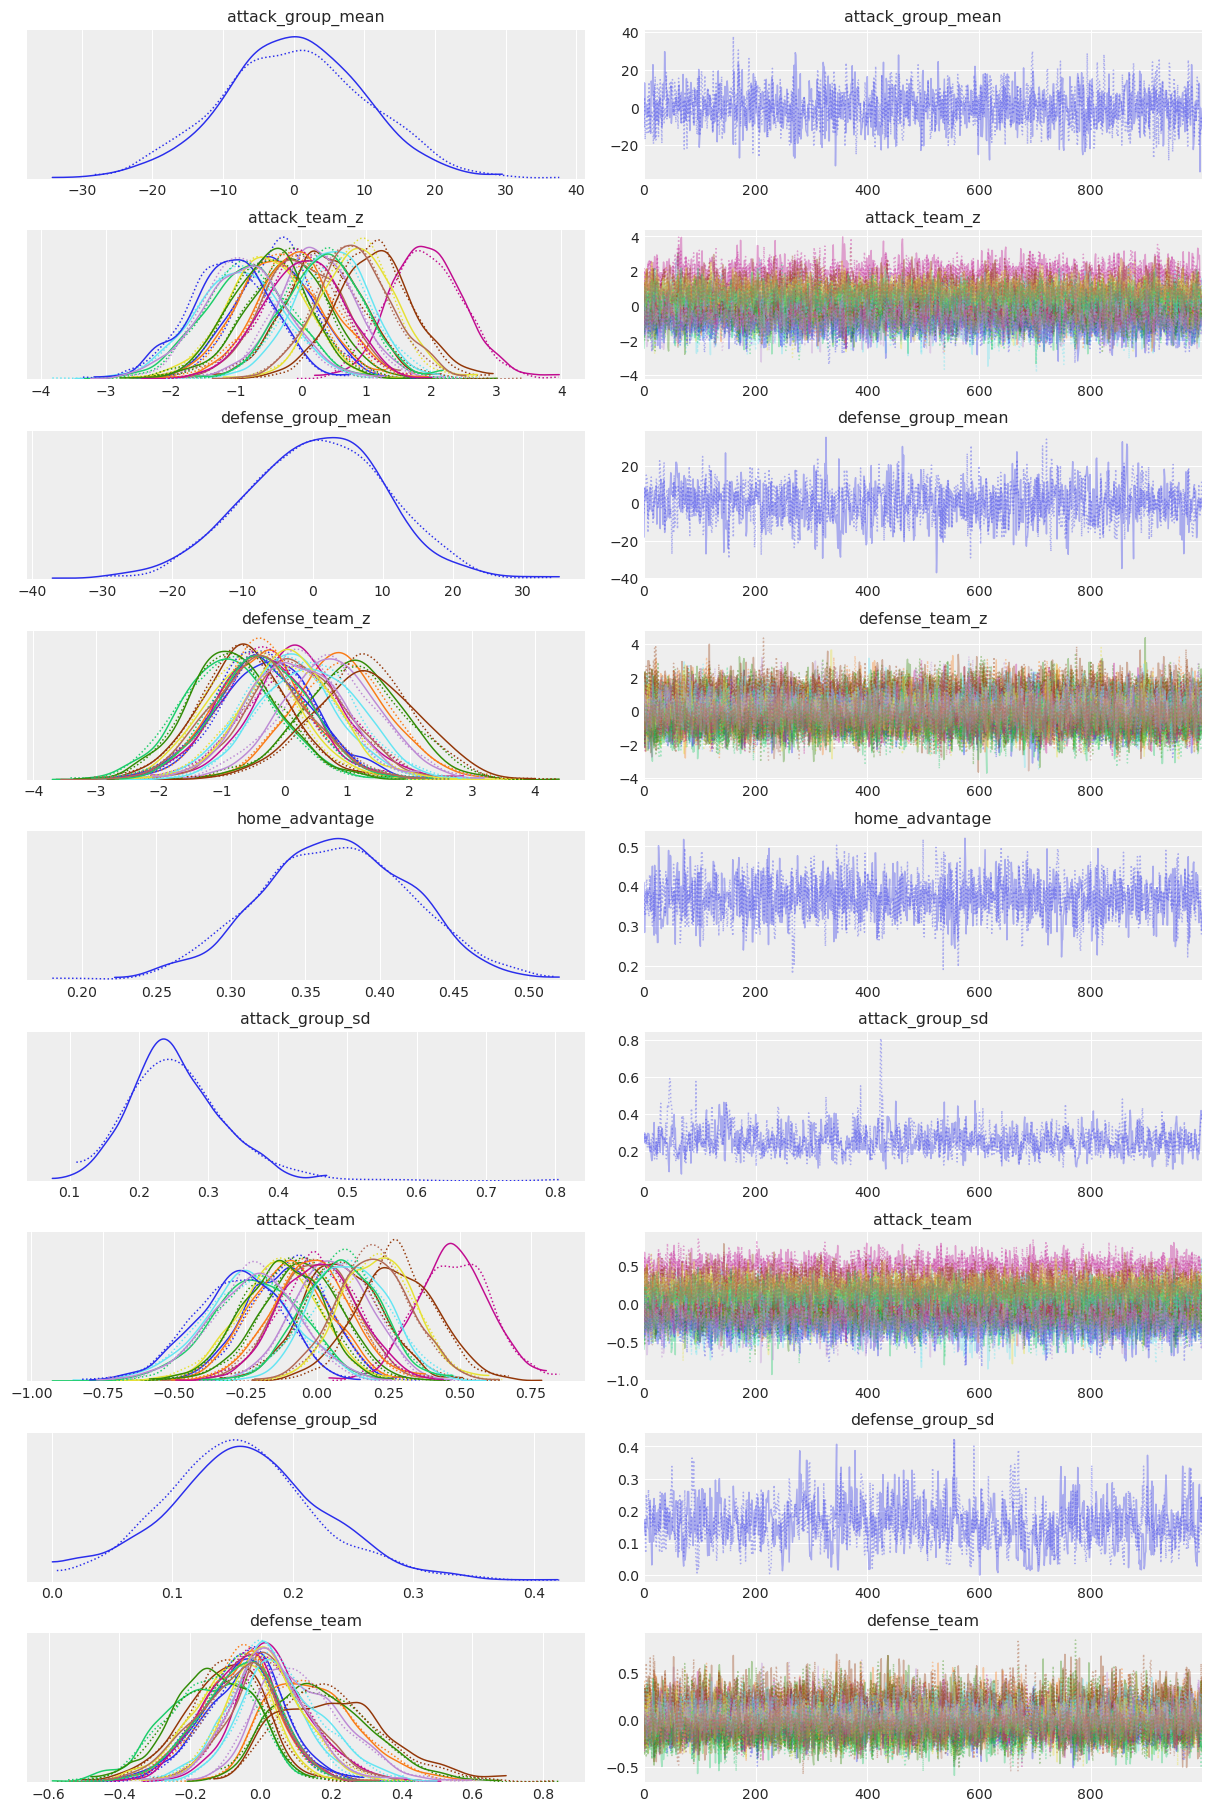

In [17]:
az.plot_trace(idata_3, compact=True)

In [18]:
az.summary(idata_3, var_names=['attack_group_mean', 'attack_group_sd', 'attack_team'], hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
attack_group_mean  0.086  9.995   -16.333     15.911      0.234    0.248   
attack_group_sd    0.256  0.069     0.153      0.359      0.003    0.002   
attack_team[0]    -0.100  0.137    -0.303      0.130      0.003    0.003   
attack_team[1]    -0.098  0.140    -0.303      0.139      0.003    0.003   
attack_team[2]    -0.059  0.142    -0.263      0.170      0.003    0.003   
attack_team[3]     0.476  0.129     0.276      0.685      0.003    0.002   
attack_team[4]     0.086  0.141    -0.145      0.304      0.003    0.003   
attack_team[5]    -0.245  0.163    -0.478      0.052      0.003    0.003   
attack_team[6]    -0.137  0.142    -0.360      0.079      0.003    0.003   
attack_team[7]    -0.211  0.157    -0.446      0.047      0.003    0.002   
attack_team[8]     0.056  0.132    -0.135      0.276      0.003    0.003   
attack_team[9]    -0.006  0.135    -0.226      0.200      0.003    0.003   
attack_team[10]   -0.279  0.153    -0.524     -0.046      0.003    0.003   
attack_team[11]   -0.023  0.140    -0.251      0.189      0.003    0.003   
attack_team[12]   -0.127  0.136    -0.347      0.080      0.003    0.002   
attack_team[13]    0.005  0.137    -0.192      0.238      0.003    0.003   
attack_team[14]    0.278  0.137     0.072      0.502      0.003    0.002   
attack_team[15]    0.114  0.137    -0.109      0.327      0.003    0.003   
attack_team[16]    0.213  0.129     0.016      0.418      0.003    0.002   
attack_team[17]    0.084  0.133    -0.136      0.281      0.003    0.003   
attack_team[18]   -0.222  0.154    -0.480      0.009      0.003    0.003   
attack_team[19]    0.198  0.129     0.007      0.417      0.003    0.002   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
attack_group_mean    1828.0   815.0    1834.0    1501.0   1.00  
attack_group_sd       663.0   592.0     754.0     644.0   1.00  
attack_team[0]       2198.0  1418.0    2220.0    1574.0   1.00  
attack_team[1]       2592.0  1461.0    2572.0    1245.0   1.00  
attack_team[2]       2060.0  1088.0    2073.0    1544.0   1.00  
attack_team[3]       2025.0  2025.0    2035.0    1485.0   1.00  
attack_team[4]       2541.0   989.0    2540.0    1192.0   1.00  
attack_team[5]       2197.0  1743.0    2208.0    1322.0   1.00  
attack_team[6]       2773.0  1604.0    2744.0    1245.0   1.00  
attack_team[7]       2305.0  1999.0    2302.0    1368.0   1.00  
attack_team[8]       1835.0  1297.0    1834.0    1597.0   1.00  
attack_team[9]       2165.0   882.0    2208.0    1358.0   1.00  
attack_team[10]      1949.0  1682.0    1982.0    1412.0   1.00  
attack_team[11]      2591.0   957.0    2591.0    1335.0   1.00  
attack_team[12]      2426.0  1843.0    2409.0    1515.0   1.00  
attack_team[13]      2143.0   932.0    2148.0    1462.0   1.00  
attack_team[14]      2357.0  2197.0    2358.0    1354.0   1.01  
attack_team[15]      1970.0  1387.0    1977.0    1289.0   1.00  
attack_team[16]      2145.0  1988.0    2138.0    1421.0   1.00  
attack_team[17]      2550.0  1386.0    2569.0    1399.0   1.00  
attack_team[18]      1992.0  1536.0    2007.0    1109.0   1.00  
attack_team[19]      2189.0  1807.0    2178.0    1438.0   1.00

In [19]:
az.summary(idata_3, var_names=['defense_group_mean', 'defense_group_sd', 'defense_team'], hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
defense_group_mean  0.443  9.926   -16.079     15.261      0.256    0.212   
defense_group_sd    0.160  0.066     0.058      0.267      0.003    0.002   
defense_team[0]    -0.044  0.114    -0.235      0.125      0.003    0.002   
defense_team[1]     0.148  0.130    -0.036      0.362      0.003    0.002   
defense_team[2]     0.177  0.140    -0.026      0.401      0.004    0.003   
defense_team[3]     0.037  0.115    -0.155      0.212      0.003    0.003   
defense_team[4]    -0.104  0.114    -0.289      0.065      0.003    0.002   
defense_team[5]     0.007  0.108    -0.152      0.188      0.003    0.002   
defense_team[6]    -0.086  0.112    -0.274      0.073      0.002    0.002   
defense_team[7]    -0.147  0.122    -0.321      0.052      0.003    0.002   
defense_team[8]     0.120  0.126    -0.059      0.329      0.003    0.003   
defense_team[9]     0.030  0.115    -0.150      0.217      0.003    0.003   
defense_team[10]   -0.062  0.113    -0.249      0.105      0.003    0.002   
defense_team[11]   -0.061  0.108    -0.242      0.101      0.003    0.002   
defense_team[12]   -0.133  0.117    -0.318      0.043      0.003    0.002   
defense_team[13]   -0.059  0.107    -0.229      0.111      0.002    0.002   
defense_team[14]    0.208  0.152    -0.037      0.422      0.004    0.003   
defense_team[15]    0.065  0.116    -0.126      0.244      0.003    0.002   
defense_team[16]    0.013  0.109    -0.158      0.184      0.002    0.002   
defense_team[17]   -0.065  0.113    -0.246      0.104      0.002    0.003   
defense_team[18]    0.021  0.108    -0.148      0.186      0.002    0.002   
defense_team[19]   -0.066  0.119    -0.263      0.115      0.003    0.002   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
defense_group_mean    1501.0  1098.0    1501.0    1317.0   1.00  
defense_group_sd       618.0   618.0     613.0     523.0   1.01  
defense_team[0]       1897.0  1118.0    1875.0    1319.0   1.00  
defense_team[1]       1505.0  1421.0    1473.0    1315.0   1.00  
defense_team[2]       1357.0  1357.0    1324.0    1304.0   1.00  
defense_team[3]       1851.0   897.0    1923.0    1393.0   1.00  
defense_team[4]       1806.0  1671.0    1787.0    1548.0   1.00  
defense_team[5]       1710.0  1182.0    1680.0    1493.0   1.00  
defense_team[6]       2140.0  1677.0    2118.0    1228.0   1.00  
defense_team[7]       1357.0  1357.0    1354.0    1507.0   1.00  
defense_team[8]       1653.0  1145.0    1717.0    1292.0   1.00  
defense_team[9]       2000.0   922.0    2006.0    1542.0   1.01  
defense_team[10]      1797.0  1442.0    1728.0    1145.0   1.00  
defense_team[11]      1668.0  1363.0    1669.0    1371.0   1.00  
defense_team[12]      1466.0  1466.0    1477.0    1435.0   1.00  
defense_team[13]      2140.0  1555.0    2134.0    1479.0   1.00  
defense_team[14]      1184.0  1184.0    1148.0    1245.0   1.00  
defense_team[15]      1951.0  1372.0    1985.0    1547.0   1.00  
defense_team[16]      2172.0  1061.0    2182.0    1664.0   1.00  
defense_team[17]      2074.0   966.0    2133.0    1280.0   1.00  
defense_team[18]      2018.0  1287.0    2047.0    1606.0   1.00  
defense_team[19]      2197.0  1188.0    2277.0    1211.0   1.00

In [20]:
az.summary(idata_3, var_names=['home_advantage'], hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
home_advantage  0.37  0.051     0.294      0.452      0.001    0.001   

                ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
home_advantage    1843.0  1837.0    1851.0    1020.0    1.0

In [21]:
home_adv = np.exp(az.summary(idata_3, var_names=['home_advantage'], hdi_prob=0.89).iloc[0, 2: 4])
print(f'{home_adv[0]} to {home_adv[1]} times more goals for the home team.')

1.3417839036669714 to 1.571451948577649 times more goals for the home team.


## Model 4

* Seperate home advantage in attack and defense.
* Equal home team advantage in attack and defense for each team.
* Sum to one constraint on the attack and defense parameters of the teams.
* Non-centered parametrization

attack_group_mean ~ Normal(0, 10)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 10)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

home_advantage_attack ~ Normal(0, 1)  
home_advantage_defense ~ Normal(0, 1)

log(home_rate<sub>i, j</sub>) = home_advantage_attack + attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub> - home_advantage_defense  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)  

$\sum_{i=1}^{20} attackteam_i$ = 0  
$\sum_{i=1}^{20} defenseteam_i$ = 0

In [46]:
with pm.Model() as model_4:
    home_team_id = pm.Data('home_team_id', df.HomeTeamId)
    away_team_id = pm.Data('away_team_id', df.AwayTeamId)
    
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team_ = attack_group_mean + attack_group_sd * attack_team_z
    attack_team = pm.Deterministic('attack_team', attack_team_ - tt.mean(attack_team_))
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team_ = defense_group_mean + defense_group_sd * defense_team_z
    defense_team = pm.Deterministic('defense_team', defense_team_ - tt.mean(defense_team_))
    
    home_advantage_attack = pm.Normal('home_advantage_attack', mu=0, sd=1)
    home_advantage_defense = pm.Normal('home_advantage_defense', mu=0, sd=1)
    
    home_rate = pm.math.exp(home_advantage_attack + attack_team[home_team_id] - defense_team[away_team_id])
    away_rate = pm.math.exp(attack_team[away_team_id] - defense_team[home_team_id] - home_advantage_defense)
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    idata_4 = pm.sample(1000, tune=2000, return_inferencedata=True,
                       idata_kwargs={
                           'coords': {'match': df.index, 'team': team_categorical.categories},
                           'dims': dims
                       })

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [home_advantage_defense, home_advantage_attack, defense_team_z, defense_group_sd, defense_group_mean, attack_team_z, attack_group_sd, attack_group_mean]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 16 seconds.


In [47]:
save_idata(idata_4, 'model_4')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0138aba90>,
      dtype=object)

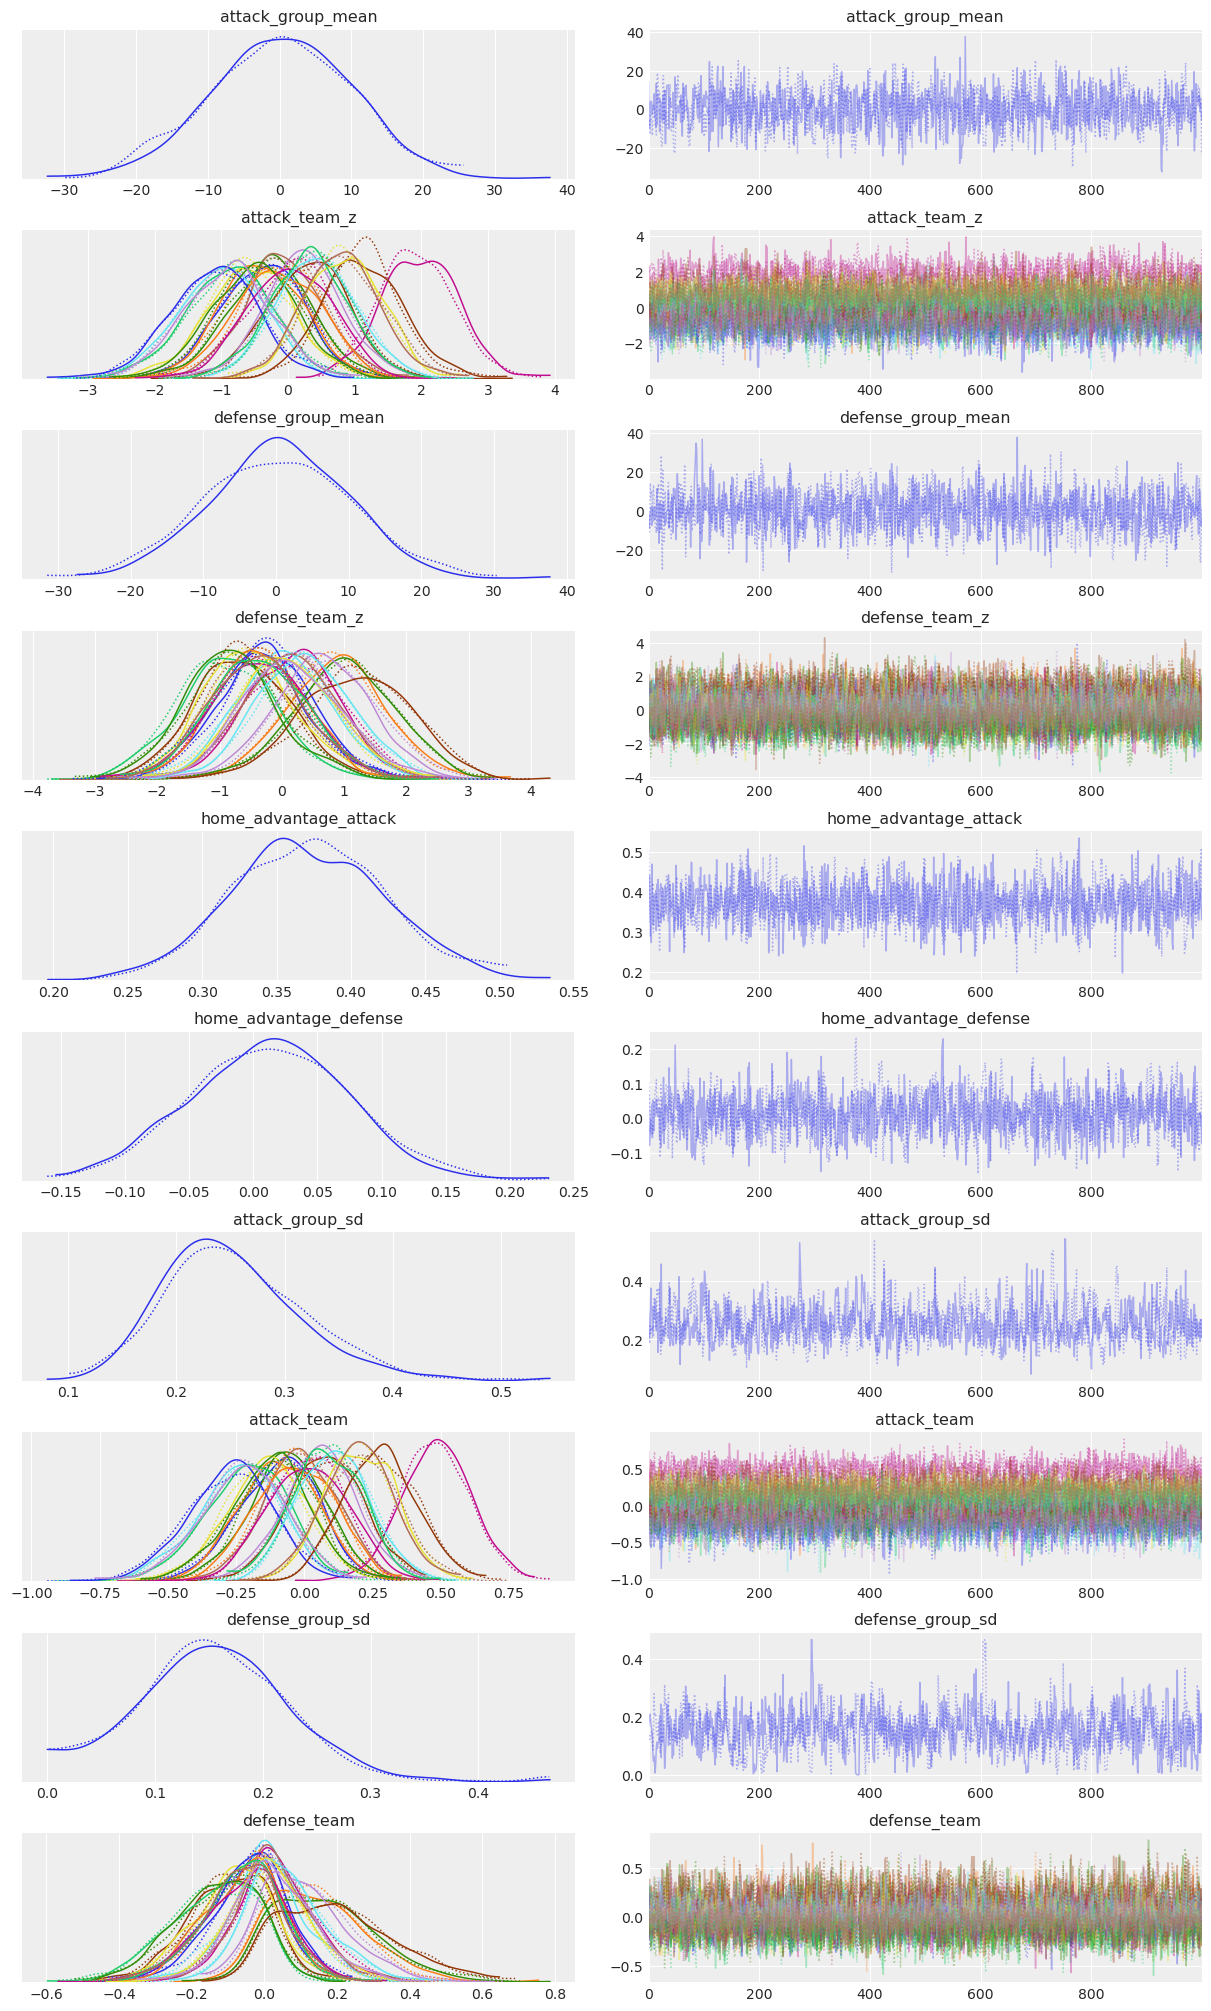

In [48]:
az.plot_trace(idata_4, compact=True)

In [49]:
az.summary(idata_4, var_names=['attack_group_mean', 'attack_group_sd', 'attack_team'], hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
attack_group_mean  0.211  9.780   -16.233     14.944      0.278    0.243   
attack_group_sd    0.253  0.064     0.152      0.351      0.002    0.002   
attack_team[0]    -0.097  0.142    -0.311      0.132      0.004    0.003   
attack_team[1]    -0.092  0.147    -0.309      0.148      0.004    0.003   
attack_team[2]    -0.065  0.141    -0.297      0.140      0.004    0.003   
attack_team[3]     0.482  0.127     0.271      0.672      0.003    0.002   
attack_team[4]     0.081  0.139    -0.139      0.299      0.003    0.003   
attack_team[5]    -0.241  0.155    -0.488      0.003      0.004    0.003   
attack_team[6]    -0.143  0.148    -0.366      0.095      0.004    0.003   
attack_team[7]    -0.215  0.152    -0.452      0.022      0.004    0.003   
attack_team[8]     0.064  0.136    -0.154      0.280      0.003    0.003   
attack_team[9]    -0.012  0.135    -0.214      0.213      0.003    0.003   
attack_team[10]   -0.274  0.157    -0.533     -0.037      0.004    0.003   
attack_team[11]   -0.033  0.141    -0.251      0.196      0.003    0.003   
attack_team[12]   -0.121  0.148    -0.355      0.111      0.004    0.003   
attack_team[13]    0.008  0.141    -0.216      0.223      0.004    0.003   
attack_team[14]    0.279  0.135     0.064      0.489      0.003    0.002   
attack_team[15]    0.111  0.133    -0.102      0.314      0.003    0.003   
attack_team[16]    0.205  0.130    -0.002      0.408      0.003    0.002   
attack_team[17]    0.084  0.130    -0.117      0.294      0.003    0.002   
attack_team[18]   -0.225  0.154    -0.492     -0.002      0.004    0.003   
attack_team[19]    0.205  0.134    -0.006      0.412      0.003    0.002   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
attack_group_mean    1238.0   811.0    1233.0     959.0    1.0  
attack_group_sd       684.0   684.0     690.0    1043.0    1.0  
attack_team[0]       1551.0  1106.0    1568.0    1174.0    1.0  
attack_team[1]       1662.0   896.0    1683.0    1031.0    1.0  
attack_team[2]       1484.0   948.0    1495.0    1187.0    1.0  
attack_team[3]       1975.0  1975.0    1979.0    1505.0    1.0  
attack_team[4]       1699.0  1345.0    1713.0    1232.0    1.0  
attack_team[5]       1676.0  1536.0    1656.0    1017.0    1.0  
attack_team[6]       1741.0  1228.0    1734.0     907.0    1.0  
attack_team[7]       1701.0  1390.0    1718.0    1356.0    1.0  
attack_team[8]       1943.0  1093.0    1942.0    1348.0    1.0  
attack_team[9]       1726.0  1129.0    1717.0    1437.0    1.0  
attack_team[10]      1642.0  1521.0    1645.0    1498.0    1.0  
attack_team[11]      1884.0   982.0    1905.0    1505.0    1.0  
attack_team[12]      1424.0  1127.0    1419.0    1126.0    1.0  
attack_team[13]      1613.0   842.0    1620.0    1297.0    1.0  
attack_team[14]      1842.0  1662.0    1838.0    1514.0    1.0  
attack_team[15]      1933.0  1334.0    1900.0    1351.0    1.0  
attack_team[16]      1702.0  1536.0    1697.0    1242.0    1.0  
attack_team[17]      1871.0  1483.0    1867.0    1313.0    1.0  
attack_team[18]      1457.0  1151.0    1498.0    1107.0    1.0  
attack_team[19]      1700.0  1600.0    1698.0    1600.0    1.0

In [50]:
az.summary(idata_4, var_names=['defense_group_mean', 'defense_group_sd', 'defense_team'], hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
defense_group_mean  0.385  9.964   -16.852     14.732      0.251    0.238   
defense_group_sd    0.154  0.069     0.034      0.254      0.003    0.002   
defense_team[0]    -0.038  0.106    -0.204      0.133      0.003    0.002   
defense_team[1]     0.140  0.130    -0.034      0.356      0.004    0.003   
defense_team[2]     0.166  0.141    -0.039      0.375      0.005    0.004   
defense_team[3]     0.034  0.112    -0.135      0.225      0.003    0.002   
defense_team[4]    -0.099  0.110    -0.286      0.060      0.003    0.002   
defense_team[5]     0.006  0.110    -0.166      0.193      0.003    0.002   
defense_team[6]    -0.081  0.114    -0.277      0.086      0.003    0.002   
defense_team[7]    -0.142  0.123    -0.341      0.030      0.004    0.003   
defense_team[8]     0.112  0.122    -0.078      0.297      0.003    0.002   
defense_team[9]     0.026  0.107    -0.145      0.194      0.003    0.002   
defense_team[10]   -0.061  0.110    -0.231      0.115      0.003    0.003   
defense_team[11]   -0.055  0.109    -0.223      0.120      0.003    0.002   
defense_team[12]   -0.126  0.119    -0.309      0.058      0.003    0.002   
defense_team[13]   -0.055  0.115    -0.246      0.119      0.003    0.002   
defense_team[14]    0.199  0.155    -0.025      0.444      0.005    0.004   
defense_team[15]    0.062  0.113    -0.107      0.250      0.003    0.002   
defense_team[16]    0.012  0.111    -0.160      0.189      0.003    0.003   
defense_team[17]   -0.060  0.112    -0.231      0.119      0.003    0.002   
defense_team[18]    0.025  0.110    -0.141      0.198      0.003    0.003   
defense_team[19]   -0.066  0.112    -0.258      0.094      0.003    0.002   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
defense_group_mean    1574.0   880.0    1584.0    1161.0    1.0  
defense_group_sd       504.0   496.0     520.0     617.0    1.0  
defense_team[0]       1312.0  1208.0    1312.0    1233.0    1.0  
defense_team[1]       1140.0  1140.0    1118.0    1379.0    1.0  
defense_team[2]        746.0   746.0     723.0    1004.0    1.0  
defense_team[3]       1940.0  1132.0    1954.0    1364.0    1.0  
defense_team[4]       1269.0  1269.0    1209.0    1597.0    1.0  
defense_team[5]       1575.0   988.0    1579.0     976.0    1.0  
defense_team[6]       1284.0  1129.0    1282.0    1254.0    1.0  
defense_team[7]       1066.0  1066.0    1035.0    1419.0    1.0  
defense_team[8]       1220.0  1213.0    1224.0    1426.0    1.0  
defense_team[9]       1721.0  1229.0    1738.0    1353.0    1.0  
defense_team[10]      1304.0   821.0    1345.0    1167.0    1.0  
defense_team[11]      1586.0  1246.0    1572.0    1204.0    1.0  
defense_team[12]      1249.0  1152.0    1266.0    1356.0    1.0  
defense_team[13]      1416.0  1169.0    1391.0    1417.0    1.0  
defense_team[14]       939.0   939.0     937.0    1396.0    1.0  
defense_team[15]      1714.0  1231.0    1709.0    1374.0    1.0  
defense_team[16]      1482.0   952.0    1487.0    1252.0    1.0  
defense_team[17]      1442.0  1156.0    1450.0    1454.0    1.0  
defense_team[18]      1578.0   924.0    1609.0    1191.0    1.0  
defense_team[19]      1620.0  1188.0    1616.0    1424.0    1.0

In [51]:
az.summary(idata_4, var_names=['home_advantage_attack', 'home_advantage_defense'], hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
home_advantage_attack   0.372  0.051     0.289      0.449      0.001    0.001   
home_advantage_defense  0.013  0.062    -0.084      0.107      0.002    0.002   

                        ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
home_advantage_attack     1748.0  1735.0    1751.0    1198.0    1.0  
home_advantage_defense    1055.0   795.0    1063.0     964.0    1.0

In [58]:
home_adv_att = np.exp(az.summary(idata_4, var_names=['home_advantage_attack'], hdi_prob=0.89).iloc[0, 2: 4])
home_adv_def = np.exp(az.summary(idata_4, var_names=['home_advantage_defense'], hdi_prob=0.89).iloc[0, 2: 4])
print(f'{home_adv_att[0]} to {home_adv_att[1]} times more goals for the home team.')
print(f'{1 / home_adv_def[0]} to {1 / home_adv_def[1]} times less goals for the away team.')

1.3350917285285084 to 1.5667446571994514 times more goals for the home team.
1.087628893808826 to 0.8985256729903055 times less goals for the away team.
